In [ ]:
!pip install openml

     |████████████████████████████████| 119 kB 5.4 MB/s 
     |████████████████████████████████| 75 kB 3.8 MB/s 
  Created wheel for openml: filename=openml-0.12.2-py3-none-any.whl size=137327 sha256=b208aa2f0f03f2580e79180bcbe5b46e5bab4a19a9e6e496641a6bfa094f5e6e
  Stored in directory: /root/.cache/pip/wheels/6a/20/88/cf4ac86aa18e2cd647ed16ebe274a5dacee9d0075fa02af250
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11731 sha256=565b1833fd4ce5ed5220d97a7086bc82fb9ed90c0a4405cf2b123eeaa223be8f
  Stored in directory: /root/.cache/pip/wheels/1f/0f/15/332ca86cbebf25ddf98518caaf887945fbe1712b97a0f2493b
Successfully built openml liac-arff


In [ ]:
import os
import numpy as np
import pandas as pd 
import tensorflow as tf
from keras.datasets import mnist
from matplotlib import pyplot
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Input, Lambda
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers, losses
import matplotlib.pyplot as plt
import openml
import math
import seaborn as sns
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Train and Test on MNIST

## load and preprocess data

In [ ]:
def load_mnist():
    (trainX, trainY), (testX, testY) = mnist.load_data()
    
    # summarize loaded dataset
    print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
    print('Test: X=%s, y=%s' % (testX.shape, testY.shape))
    
    # reshape dataset to have a single faltten shape
    trainX = trainX.reshape((trainX.shape[0], 28 * 28))
    testX = testX.reshape((testX.shape[0], 28 * 28))

    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)

    return trainX, trainY, testX, testY

In [ ]:
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	
    # normalize to range (0, 1)
	train_norm = (train_norm) / 255.0
	test_norm = (test_norm) / 255.0
	
    # return normalized images
	return train_norm, test_norm

## Define the model

In [ ]:
# building model
class VAE(object):
    def build_model(self, intermediate_dim, latent_dim, original_dim, kl_weight_start = 0, epsilon_std=1.):

        """
        Creates a Variational Autoencoder (VAE). Returns VAE, Encoder, Generator. 
        # Arguments
            latent_dim: int, latent z-layer shape. 
            epsilon_std: float, z-layer sigma.
        # References
            - [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
        """        
        self.vae = None
        self.encoder = None
        self.decoder = None

        inputs = Input(shape=(original_dim, ))
        h = Dense(intermediate_dim, activation='relu', kernel_initializer='he_uniform')(inputs)

        # VAE Z layer
        z_mean = Dense(latent_dim)(h)
        z_log_sigma = Dense(latent_dim)(h)

        def sampling(args):
            z_mean, z_log_sigma = args
            epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
            return z_mean + K.exp(z_log_sigma) * epsilon

        z = Lambda(sampling)([z_mean, z_log_sigma])

        # Create encoder
        self.encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

        # Create decoder
        latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
        x = Dense(intermediate_dim, activation='relu')(latent_inputs)
        outputs = Dense(original_dim, activation='sigmoid')(x)
        self.decoder = Model(latent_inputs, outputs, name='decoder')

        # instantiate VAE model
        outputs = self.decoder(self.encoder(inputs)[2])
        self.vae = Model(inputs, outputs, name='vae_mlp')

        reconstruction_loss = losses.binary_crossentropy(inputs, outputs)
        reconstruction_loss *= original_dim
        kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        self.vae.add_loss(vae_loss)
        self.vae.compile(optimizer='adam')

In [ ]:
def create_ensemble(model_class, k, model_params):
    models = []
    for i in range(k):
        model = model_class()
        model.build_model(
            intermediate_dim=model_params['intermediate_dim'],
            latent_dim=model_params['latent_dim'], original_dim=model_params['original_dim'])
        models.append(model)
    
    return models

def train_ensemble(models, model_name, x_train, y_train, x_test, y_test, epochs = 100, batch_size = 62):
    base_path = "/content/gdrive/My Drive/Fairness_Project/"

    # train models
    results = []
    n = len(x_train)
    k = len(models)
    for i in range(k):
        print("Training Model {}".format(i + 1))
        index = np.r_[0:int(i * n / k), int((i + 1) * n / k):]
        x = x_train[index]
        y = y_train[index]
        
        # Create a callback that saves the model's weights
        checkpoint_path = base_path + model_name + str(i) + "_cp.ckpt"
        checkpoint_dir = os.path.dirname(checkpoint_path)
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True)
        
        results.append(
            models[i].vae.fit(
                x, x,
                batch_size = batch_size,
                epochs = epochs,
                validation_split=0.3,
                validation_data=(x_test, x_test),
                callbacks=[
                   cp_callback
                ]
            )
        )

    return results

## Train and Test ensemble models

In [ ]:
x_train, y_train, x_test, y_test = load_mnist()
x_train_normalized, x_test_normalized = prep_pixels(x_train, x_test)

11501568/11490434 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


In [ ]:
# save original dataset
x_train_normalized = x_train_normalized[:5000]
x_test_normalized = x_test_normalized[:5000]
y_train = y_train[:5000]
y_test = y_test[:5000]

In [ ]:
mnist_df_train = pd.DataFrame(data=np.concatenate((x_train_normalized, np.argmax(y_train, axis=1).reshape(-1, 1)), axis=1))
mnist_df_test = pd.DataFrame(data=np.concatenate((x_test_normalized, np.argmax(y_test, axis=1).reshape(-1, 1)), axis=1))

mnist_df_train.to_csv('/content/gdrive/My Drive/Fairness_Project/Original/mnist_5000_train.csv', index=False)
mnist_df_test.to_csv('/content/gdrive/My Drive/Fairness_Project/Original/mnist_5000_test.csv', index=False)

In [ ]:
mnist_df_train = pd.DataFrame(data=np.concatenate((np.concatenate((x_train_normalized, np.argmax(y_train, axis=1).reshape(-1, 1)), axis=1), np.concatenate((x_test_normalized, np.argmax(y_test, axis=1).reshape(-1, 1)), axis=1))))

mnist_df_train.to_csv('/content/gdrive/My Drive/Fairness_Project/Original/mnist_10000.csv', index=False)

## results on other models

In [ ]:
# dp-wgan
df = pd.read_csv('/content/gdrive/My Drive/Fairness_Project/Synthesized/mnist_5000_dpwgan.csv')

In [ ]:
dpwgan_numpy = df.to_numpy()
dpwgan_y = dpwgan_numpy[:, 784]
dpwgan_x = dpwgan_numpy[:, :784]

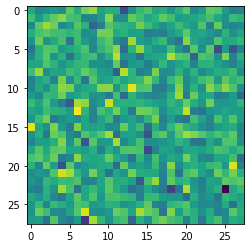

In [ ]:
plt.imshow(dpwgan_x[0].reshape((28, 28)))

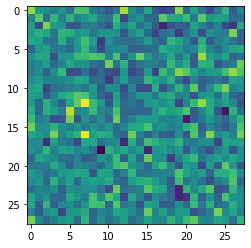

In [ ]:
plt.imshow(dpwgan_x[1].reshape((28, 28)))

In [ ]:
# pate-gan
df = pd.read_csv('/content/gdrive/My Drive/Fairness_Project/Synthesized/mnist_5000_pategan.csv')

In [ ]:
pategan_numpy = df.to_numpy()
pategan_y = pategan_numpy[:, 784]
pategan_x = pategan_numpy[:, :784]

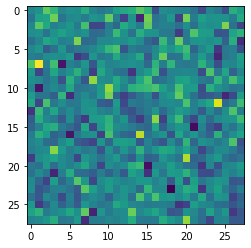

In [ ]:
plt.imshow(pategan_x[0].reshape((28, 28)))

In [ ]:
pate = np.loadtxt('/content/gdrive/My Drive/Fairness_Project/Synthesized/synthesize.txt')

In [ ]:
pate_x = pate[:, :784]

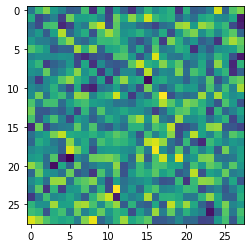

In [ ]:
plt.imshow(pate_x[0].reshape((28, 28)))

## My model


train model

In [ ]:
models = create_ensemble(VAE, 10, {'intermediate_dim':64, 'latent_dim':2, 'input_size_h':28, 'input_size_w':28, 'original_dim': 28 * 28})

In [ ]:
results = train_ensemble(
    models,
    'MNIST_5000_Model_10',
    x_train_normalized,
    y_train,
    x_test_normalized,
    y_test,
    epochs = 100,
    batch_size = 62
)

In [ ]:
def load_model(model_class, model_name, no_ensembles, model_params):
    models = []
    for i in range(no_ensembles):
        model = model_class()
        model.build_model(
            intermediate_dim=model_params['intermediate_dim'],
            latent_dim=model_params['latent_dim'],
            original_dim=model_params['original_dim'])
        models.append(model)
    
    base_path = "/content/gdrive/My Drive/Fairness_Project/"

    for i in range(no_ensembles):
        checkpoint_path = base_path + model_name + str(i) + "_cp.ckpt"
        checkpoint_dir = os.path.dirname(checkpoint_path)
        models[i].vae.load_weights(checkpoint_path)

    return models

In [ ]:
MNIST_ensemble = load_model(VAE, 'MNIST_5000_Model_10', 10, {'intermediate_dim':64, 'latent_dim':2, 'input_size_h':28, 'input_size_w':28, 'original_dim': 28 * 28})

create samples

In [ ]:
def sampling(models, latent_size, mean=0.0, std=1.0):
    samples = []
    for i in range(len(models)):
        model = models[i]
        s = K.random_normal(shape=(1, latent_size), mean=mean, stddev=std)
        samples.append(model.decoder.predict(s))
    
    return samples

### Sample Selection

In [ ]:
def sample_selection(dataset, samples, noise):
    samples_nn = []
    for i in range(len(samples)):
        # find closest individual
        nn = float('inf')
        for j in range(len(dataset)):
            distance = np.linalg.norm(samples[i] - dataset[j])
            if distance < nn:
                nn = distance
        # print(nn)
        samples_nn.append(nn + np.random.laplace(0, noise, 1))
    # print("----")
    # print(samples_nn)
    return samples[np.argmax(samples_nn)]

In [ ]:
selected_sample = sample_selection(x_train_normalized, sampling(MNIST_ensemble, 2), 1)

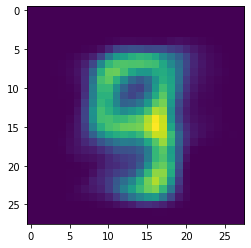

In [ ]:
plt.imshow(selected_sample.reshape((28, 28)))

show 16 of created samples


In [ ]:
f, axarr = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        selected_sample = sample_selection(x_train, sampling(MNIST_ensemble, 2), 1)
        axarr[i,j].imshow(selected_sample.reshape((28, 28)))

In [ ]:
# synthesized = []
for i in range(len(x_train) - len(synthesized)):
    selected_sample = sample_selection(x_train, sampling(MNIST_ensemble, 2), 1)
    synthesized.append(selected_sample[0])
    if i % 1000 == 0:
        print(i)
    
    if(len(synthesized)) == 2000:
        break

synthesized = np.array(synthesized)

np.savetxt("/content/gdrive/My Drive/Fairness_Project/Synthesized/mnist_5000_mymodel_10.txt", synthesized)

0


# Train on Adult Census

## Preprocess data

In [ ]:
def load_census():
    # This is done based on the dataset ID.
    census = openml.datasets.get_dataset(1119)

    # Print a summary
    print(
        f"This is dataset '{census.name}', the target feature is "
        f"'{census.default_target_attribute}'"
    )
    print(f"URL: {census.url}")
    print(census.description[:500])

    census_dataframe, census_target, _, census_attribute_names = census.get_data(
        target=census.default_target_attribute, dataset_format="dataframe"
    )

    # pre-process
    census_dataframe = census_dataframe.rename(columns={"fnlwgt:": "fnlwgt", "education:": "education", "education-num:" : "education-num",
                    "marital-status:" : "marital-status", "occupation:" : "occupation", "relationship:" : "relationship",
                    "race:" : "race", "sex:" : "sex", "capital-gain:" : "capital-gain", "capital-loss:" : "capital-loss",
                    "hours-per-week:" : "hours-per-week", "native-country:" : "native-country"
                    })

    
    census_whole = pd.concat([census_dataframe, census_target], axis=1)

    census_whole.drop(["fnlwgt", "education-num", "relationship"], axis=1, inplace=True)
    cleaned_census = pd.get_dummies(data=census_whole, columns=['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'native-country'])

    cleaned_census = cleaned_census.replace(["<=50K", '>50K'], [0, 1])

    temp_cols = cleaned_census.columns.tolist()
    index = cleaned_census.columns.get_loc("class")
    new_cols = temp_cols[0:index] + temp_cols[index+1:] + temp_cols[index:index+1]
    
    return cleaned_census[new_cols]

In [ ]:
census = load_census()

This is dataset 'adult-census', the target feature is 'class'
URL: https://www.openml.org/data/v1/download/54002/adult-census.arff
**Author**: Ronny Kohavi and Barry Becker  
**Source**: [MLRR](http://axon.cs.byu.edu:5000/)    
**Please cite**: Ron Kohavi, "Scaling Up the Accuracy of Naive-Bayes Classifiers: a Decision-Tree Hybrid", Proceedings of the Second International Conference on Knowledge Discovery and Data Mining, 1996  

Dataset from the MLRR repository: http://axon.cs.byu.edu:5000/

**Note: this dataset is identical to the version stored in UCI, but only includes the training data, not the test data. See [adult (2


## Train and Test Ensemble

In [ ]:
# save only 5000 of file to test and train on
census_df_train = census[:5000]
census_df_test = census[5000:10000]
census_df_train.to_csv('/content/gdrive/My Drive/Fairness_Project/Original/census_5000_train.csv', index=False)
census_df_test.to_csv('/content/gdrive/My Drive/Fairness_Project/Original/census_5000_test.csv', index=False)

In [ ]:
census_numpy = census[:10000].to_numpy()
max_census = np.max(census_numpy, axis=0)
max_census[max_census==0] = 1
normalized_census = census_numpy / max_census

In [ ]:
# save only 5000 of file to test and train on
census_df_train = census[:5000] / max_census
census_df_test = census[5000:10000] / max_census
census_df_train.to_csv('/content/gdrive/My Drive/Fairness_Project/Original/census_5000_train_normalized.csv', index=False)
census_df_test.to_csv('/content/gdrive/My Drive/Fairness_Project/Original/census_5000_test_normalized.csv', index=False)

In [ ]:
x_train = normalized_census[:5000]
x_test = normalized_census[5000:10000]

In [ ]:
models = create_ensemble(VAE, 10, {'intermediate_dim':64, 'latent_dim':4, 'original_dim': x_train.shape[1]})

In [ ]:
results = train_ensemble(
    models,
    'CENSUS_5000_Model_10',
    x_train,
    x_train[:, 4],
    x_test,
    x_test[:, 4],
    epochs = 100,
    batch_size = 62
)

In [ ]:
CENSUS_ensemble = load_model(VAE, 'CENSUS_5000_Model_10', 10, {'intermediate_dim':64, 'latent_dim':4, 'original_dim': x_train.shape[1]})

In [ ]:
CENSUS_ensemble[0].vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 98)]         0           []                               
                                                                                                  
 encoder (Functional)           [(None, 4),          6856        ['input_1[0][0]']                
                                 (None, 4),                                                       
                                 (None, 4)]                                                       
                                                                                                  
 decoder (Functional)           (None, 98)           6690        ['encoder[0][2]']                
                                                                                            

In [ ]:
selected_sample = sample_selection(x_train, sampling(CENSUS_ensemble, 4), 1)

In [ ]:
def sample_to_census(sample):
    unnormalize = sample * max_census   
     
    df = pd.DataFrame(data=unnormalize, columns=census.columns)
    df["age"] = df["age"].astype(int)

    df["capital-gain"] = df["capital-gain"].astype(int).astype(float)
    df["capital-loss"] = df["capital-loss"].astype(int).astype(float)
    df["hours-per-week"] = df["hours-per-week"].astype(int)
    df["class"] = round(df["class"]).astype(int)
    return df

In [ ]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [ ]:
sample_to_census(selected_sample)

,age,capital-gain,capital-loss,hours-per-week,class,workclass_Private,workclass_Self-emp-not-inc,workclass_Self-emp-inc,workclass_Federal-gov,workclass_Local-gov,workclass_State-gov,workclass_Without-pay,workclass_Never-worked,education_Bachelors,education_Some-college,education_11th,education_HS-grad,education_Prof-school,education_Assoc-acdm,education_Assoc-voc,education_9th,education_7th-8th,education_12th,education_Masters,education_1st-4th,education_10th,education_Doctorate,education_5th-6th,education_Preschool,marital-status_Married-civ-spouse,marital-status_Divorced,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,marital-status_Married-spouse-absent,marital-status_Married-AF-spouse,occupation_Tech-support,occupation_Craft-repair,occupation_Other-service,occupation_Sales,...,native-country_Cambodia,native-country_England,native-country_Puerto-Rico,native-country_Canada,native-country_Germany,native-country_Outlying-US(Guam-USVI-etc),native-country_India,native-country_Japan,native-country_Greece,native-country_South,native-country_China,native-country_Cuba,native-country_Iran,native-country_Honduras,native-country_Philippines,native-country_Italy,native-country_Poland,native-country_Jamaica,native-country_Vietnam,native-country_Mexico,native-country_Portugal,native-country_Ireland,native-country_France,native-country_Dominican-Republic,native-country_Laos,native-country_Ecuador,native-country_Taiwan,native-country_Haiti,native-country_Columbia,native-country_Hungary,native-country_Guatemala,native-country_Nicaragua,native-country_Scotland,native-country_Thailand,native-country_Yugoslavia,native-country_El-Salvador,native-country_Trinadad&Tobago,native-country_Peru,native-country_Hong,native-country_Holand-Netherlands
0,37,10501.0,331.0,46,0.0,0.600153,0.190261,0.168265,0.169577,0.124364,0.218134,0.096066,0.107687,0.274989,0.32184,0.178654,0.397797,0.114067,0.170239,0.269295,0.151946,0.149344,0.093718,0.166579,0.094073,0.090458,0.122191,0.100699,0.102672,0.515592,0.249729,0.343292,0.147025,0.105381,0.104092,0.115914,0.228215,0.221922,0.205173,0.215532,...,0.084856,0.079111,0.145069,0.068911,0.077587,0.105015,0.151888,0.087391,0.087059,0.090353,0.069422,0.124339,0.097763,0.102121,0.106062,0.066116,0.099346,0.11328,0.092004,0.168462,0.07509,0.101666,0.138472,0.10079,0.097339,0.139657,0.085799,0.069655,0.075329,0.063216,0.095864,0.088566,0.088757,0.104768,0.097828,0.067427,0.091765,0.097157,0.076232,0.141437


In [ ]:
undummify(sample_to_census(selected_sample))

,age,capital-gain,capital-loss,hours-per-week,class,workclass,education,marital-status,occupation,race,sex,native-country
0,37,10501.0,331.0,46,0.0,Private,HS-grad,Married-civ-spouse,Exec-managerial,White,Male,United-States


## create and save a new synthesized dataset

In [ ]:
synthesized = []
for i in range(len(x_train)):
    selected_sample = sample_selection(x_train, sampling(CENSUS_ensemble, 4), 1)
    synthesized.append(selected_sample[0])

synthesized = np.array(synthesized)

np.savetxt("/content/gdrive/My Drive/Fairness_Project/Synthesized/census_5000_mymodel_10.txt", synthesized)

# Calculating the statistical similarities

## Census

### Covariance matrix

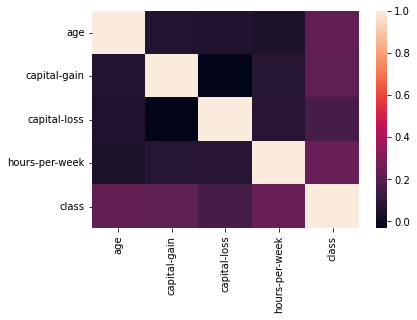

In [ ]:
# covariance of original dataset
origin_df = undummify(sample_to_census(x_train))
origin_cov = origin_df.corr() 
sns.heatmap(origin_cov, 
        xticklabels=origin_cov.columns,
        yticklabels=origin_cov.columns)

In [ ]:
origin_cov

,age,capital-gain,capital-loss,hours-per-week,class
age,1.000000,0.062991,0.056268,0.039622,0.228991
capital-gain,0.062991,1.000000,-0.033438,0.071915,0.218062
capital-loss,0.056268,-0.033438,1.000000,0.079381,0.159685
hours-per-week,0.039622,0.071915,0.079381,1.000000,0.241109
class,0.228991,0.218062,0.159685,0.241109,1.000000


In [ ]:
# cov matrix of my model
synthesized = np.loadtxt("/content/gdrive/My Drive/Fairness_Project/Synthesized/census_5000_mymodel_10.txt")

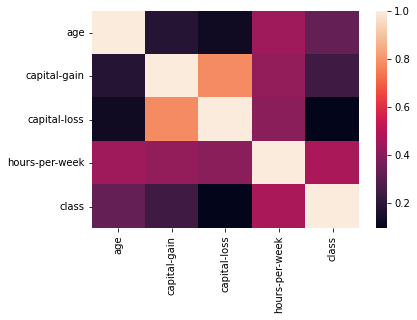

In [ ]:
# covariance of original dataset
mymodel_df = undummify(sample_to_census(synthesized))
mymodel_cov = mymodel_df.corr() 
sns.heatmap(mymodel_cov,
        xticklabels=mymodel_cov.columns,
        yticklabels=mymodel_cov.columns)

In [ ]:
mymodel_cov

,age,capital-gain,capital-loss,hours-per-week,class
age,1.000000,0.183218,0.129900,0.451571,0.330123
capital-gain,0.183218,1.000000,0.782889,0.427974,0.242779
capital-loss,0.129900,0.782889,1.000000,0.406795,0.093495
hours-per-week,0.451571,0.427974,0.406795,1.000000,0.475510
class,0.330123,0.242779,0.093495,0.475510,1.000000


In [ ]:
# square error between my model and original one
(mymodel_cov - origin_cov) ** 2

,age,capital-gain,capital-loss,hours-per-week,class
age,0.000000,0.014454,0.005422,0.169702,0.010228
capital-gain,0.014454,0.000000,0.666390,0.126777,0.000611
capital-loss,0.005422,0.666390,0.000000,0.107200,0.004381
hours-per-week,0.169702,0.126777,0.107200,0.000000,0.054944
class,0.010228,0.000611,0.004381,0.054944,0.000000


In [ ]:
((mymodel_cov - origin_cov) ** 2).sum()

age               0.199806
capital-gain      0.808232
capital-loss      0.783392
hours-per-week    0.458623
class             0.070163
dtype: float64

In [ ]:
# cov matrix of dp-gan
census_dpgan = pd.read_csv("/content/gdrive/My Drive/Fairness_Project/Synthesized/census_5000_dpgan.csv", index_col=0)

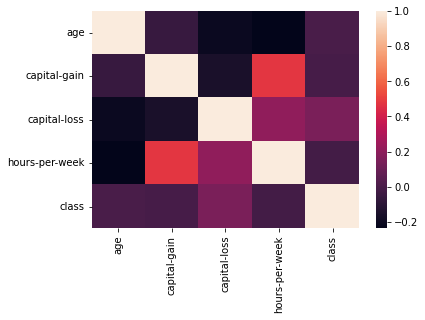

In [ ]:
# covariance of original dataset
census_dpgan_df = undummify(sample_to_census(census_dpgan))
census_dpgan_cov = census_dpgan_df.corr() 
sns.heatmap(census_dpgan_cov,
        xticklabels=census_dpgan_cov.columns,
        yticklabels=census_dpgan_cov.columns)

In [ ]:
census_dpgan_cov

,age,capital-gain,capital-loss,hours-per-week,class
age,1.000000,-0.054980,-0.199219,-0.236590,0.002511
capital-gain,-0.054980,1.000000,-0.151030,0.482393,-0.009379
capital-loss,-0.199219,-0.151030,1.000000,0.212584,0.148201
hours-per-week,-0.236590,0.482393,0.212584,1.000000,-0.014855
class,0.002511,-0.009379,0.148201,-0.014855,1.000000


In [ ]:
# square error between my model and original one
(census_dpgan_cov - origin_cov) ** 2

,age,capital-gain,capital-loss,hours-per-week,class
age,0.000000,0.013917,0.065274,0.076293,0.051293
capital-gain,0.013917,0.000000,0.013828,0.168492,0.051729
capital-loss,0.065274,0.013828,0.000000,0.017743,0.000132
hours-per-week,0.076293,0.168492,0.017743,0.000000,0.065517
class,0.051293,0.051729,0.000132,0.065517,0.000000


In [ ]:
((census_dpgan_cov - origin_cov) ** 2).sum()

age               0.206777
capital-gain      0.247967
capital-loss      0.096976
hours-per-week    0.328045
class             0.168672
dtype: float64

In [ ]:
# cov matrix of pate-gan
census_pategan = np.loadtxt("/content/gdrive/My Drive/Fairness_Project/Synthesized/census_5000_pategan_paper.txt")

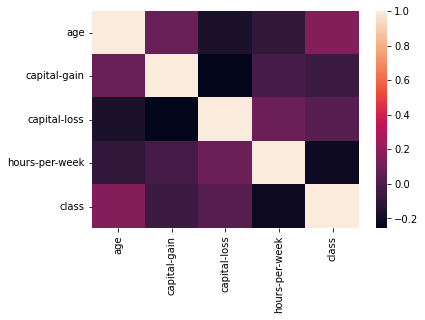

In [ ]:
# covariance of original dataset
census_pategan_df = undummify(sample_to_census(census_pategan))
census_pategan_cov = census_pategan_df.corr() 
sns.heatmap(census_pategan_cov,
        xticklabels=census_pategan_cov.columns,
        yticklabels=census_pategan_cov.columns)

In [ ]:
# square error between pate gan and original one
(census_pategan_cov - origin_cov) ** 2

,age,capital-gain,capital-loss,hours-per-week,class
age,0.000000,0.000183,0.049297,0.017471,0.004621
capital-gain,0.000183,0.000000,0.050346,0.010277,0.074600
capital-loss,0.049297,0.050346,0.000000,0.000121,0.018840
hours-per-week,0.017471,0.010277,0.000121,0.000000,0.209709
class,0.004621,0.074600,0.018840,0.209709,0.000000


In [ ]:
# square error between pate gan and original one
((census_pategan_cov - origin_cov) ** 2).sum()

age               0.071572
capital-gain      0.135406
capital-loss      0.118604
hours-per-week    0.237578
class             0.307770
dtype: float64

### momentums

In [ ]:
origin_df.mean(axis=0)

age                 38.5326
capital-gain      1033.6284
capital-loss        93.6952
hours-per-week      40.5150
class                0.2442
dtype: float64

In [ ]:
mymodel_df.mean(axis=0)

age                 37.5152
capital-gain      8187.5314
capital-loss       298.2812
hours-per-week      40.5828
class                0.3610
dtype: float64

In [ ]:
census_dpgan_df.mean(axis=0)

age                   1.7792
capital-gain      11579.4356
capital-loss       -499.8672
hours-per-week       -8.5138
class                 0.2514
dtype: float64

In [ ]:
census_pategan_df.mean(axis=0)

age                  44.472145
capital-gain      50058.197550
capital-loss       2191.371395
hours-per-week       49.421968
class                 0.500198
dtype: float64

In [ ]:
origin_df.var(axis=0)

age               1.842814e+02
capital-gain      4.972772e+07
capital-loss      1.687529e+05
hours-per-week    1.465983e+02
class             1.846033e-01
dtype: float64

In [ ]:
census_dpgan_df.var(axis=0)

age               1.062483e+03
capital-gain      1.481932e+09
capital-loss      1.856199e+06
hours-per-week    1.357706e+03
class             1.882357e-01
dtype: float64

In [ ]:
census_pategan_df.var(axis=0)

age               2.101505e+02
capital-gain      2.485816e+08
capital-loss      4.581812e+05
hours-per-week    3.388614e+02
class             2.500988e-01
dtype: float64

In [ ]:
mymodel_df.var(axis=0)

age               9.927242e+01
capital-gain      2.732494e+08
capital-loss      2.453345e+05
hours-per-week    5.432961e+01
class             2.307251e-01
dtype: float64

### histogram

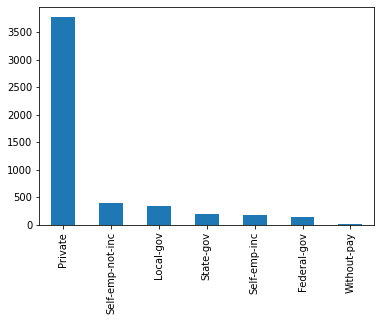

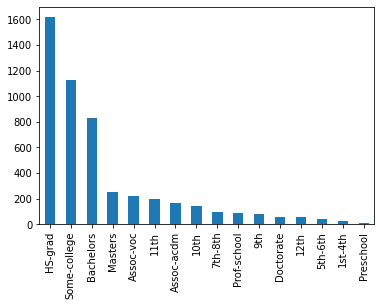

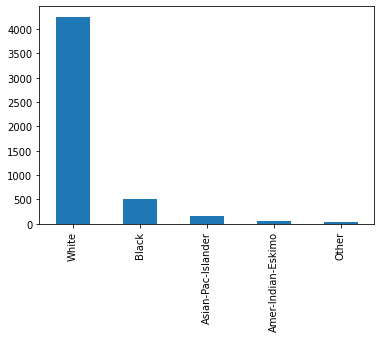

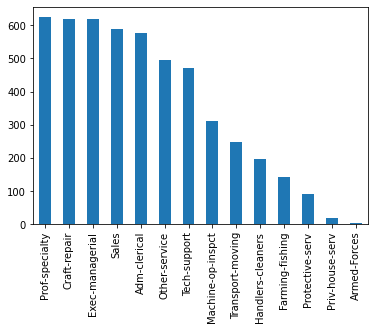

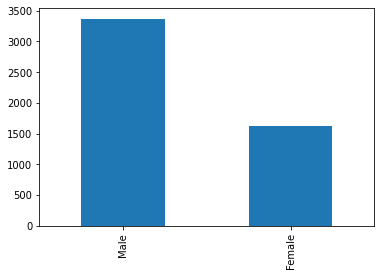

In [ ]:
origin_df['workclass'].value_counts().plot(kind='bar')
plt.show()
origin_df['education'].value_counts().plot(kind='bar')
plt.show()
origin_df['race'].value_counts().plot(kind='bar')
plt.show()
origin_df['occupation'].value_counts().plot(kind='bar')
plt.show()
origin_df['sex'].value_counts().plot(kind='bar')
plt.show()

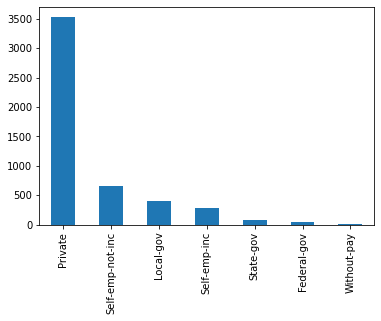

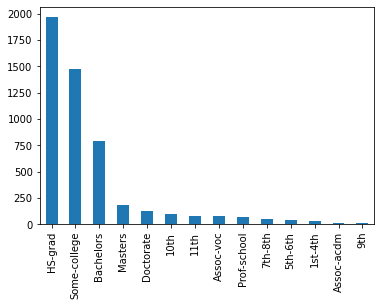

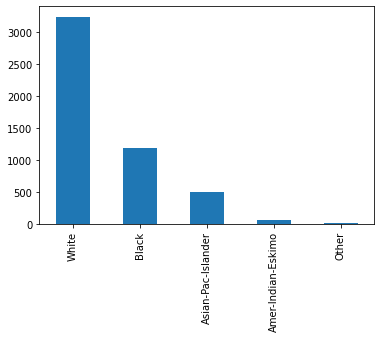

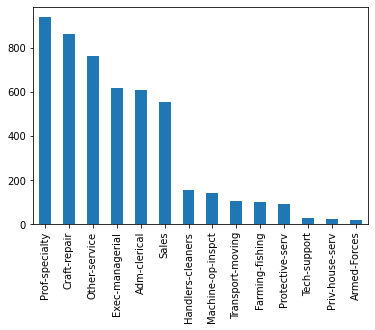

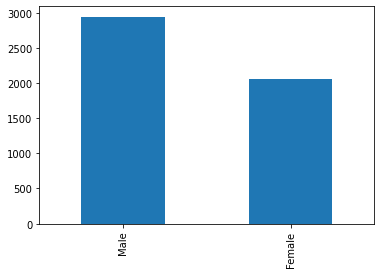

In [ ]:
mymodel_df['workclass'].value_counts().plot(kind='bar')
plt.show()
mymodel_df['education'].value_counts().plot(kind='bar')
plt.show()
mymodel_df['race'].value_counts().plot(kind='bar')
plt.show()
mymodel_df['occupation'].value_counts().plot(kind='bar')
plt.show()
mymodel_df['sex'].value_counts().plot(kind='bar')

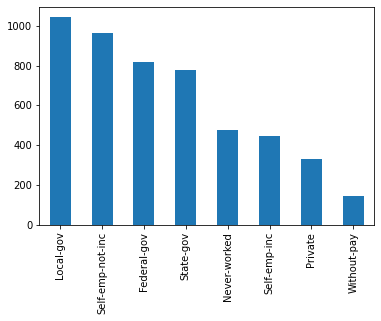

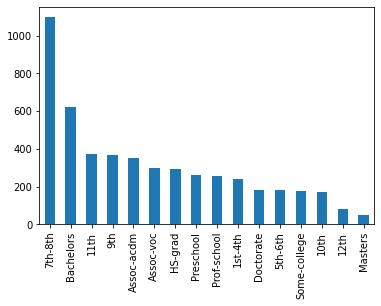

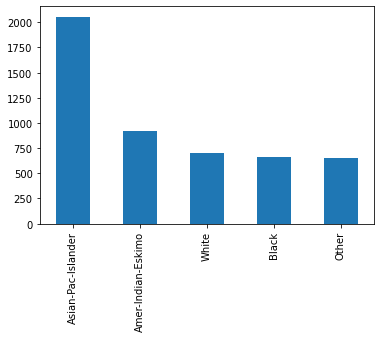

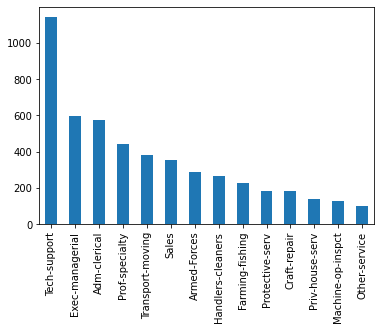

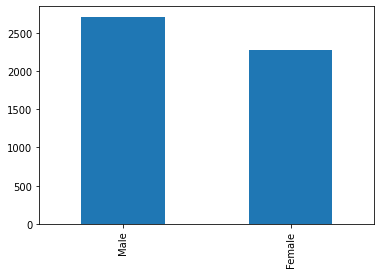

In [ ]:
census_dpgan_df['workclass'].value_counts().plot(kind='bar')
plt.show()
census_dpgan_df['education'].value_counts().plot(kind='bar')
plt.show()
census_dpgan_df['race'].value_counts().plot(kind='bar')
plt.show()
census_dpgan_df['occupation'].value_counts().plot(kind='bar')
plt.show()
census_dpgan_df['sex'].value_counts().plot(kind='bar')
plt.show()

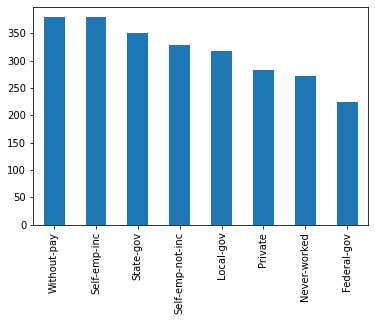

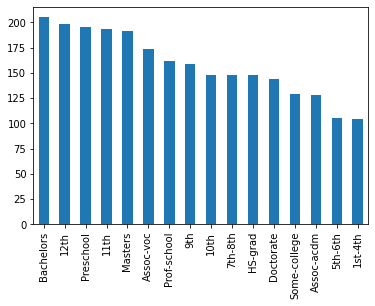

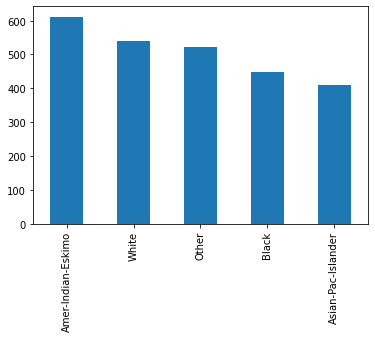

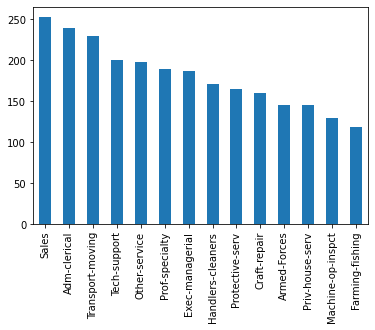

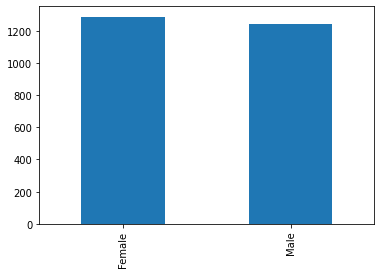

In [ ]:
census_pategan_df['workclass'].value_counts().plot(kind='bar')
plt.show()
census_pategan_df['education'].value_counts().plot(kind='bar')
plt.show()
census_pategan_df['race'].value_counts().plot(kind='bar')
plt.show()
census_pategan_df['occupation'].value_counts().plot(kind='bar')
plt.show()
census_pategan_df['sex'].value_counts().plot(kind='bar')
plt.show()

### weighted distance

In [ ]:
((mymodel_cov - origin_cov) ** 2).sum().sum() \
+ 1/50 * ((1 - mymodel_df.mean(axis=0) / origin_df.mean(axis=0)) ** 2).sum() \
+ 1/20 * ((1 - mymodel_df.var(axis=0) / origin_df.var(axis=0)) ** 2).sum() \
+ 1/2 * ((1 - mymodel_df['sex'].value_counts() / origin_df['sex'].value_counts()) ** 2).sum() \
+ 1/5 * ((1 - mymodel_df['race'].value_counts() / origin_df['race'].value_counts()) ** 2).sum() \

5.9794751110316335

In [ ]:
((census_dpgan_cov - origin_cov) ** 2).sum().sum() \
+ 1/50 * ((1 - census_dpgan_df.mean(axis=0) / origin_df.mean(axis=0)) ** 2).sum() \
+ 1/20 * ((1 - census_dpgan_df.var(axis=0) / origin_df.var(axis=0)) ** 2).sum() \
+ 1/2 * ((1 - census_dpgan_df['sex'].value_counts() / origin_df['sex'].value_counts()) ** 2).sum() \
+ 1/5 * ((1 - census_dpgan_df['race'].value_counts() / origin_df['race'].value_counts()) ** 2).sum() \

236.1874392384073

In [ ]:
((census_pategan_cov - origin_cov) ** 2).sum().sum() \
+ 1/50 * ((1 - census_pategan_df.mean(axis=0) / origin_df.mean(axis=0)) ** 2).sum() \
+ 1/20 * ((1 - census_pategan_df.var(axis=0) / origin_df.var(axis=0)) ** 2).sum() \
+ 1/2 * ((1 - census_pategan_df['sex'].value_counts() / origin_df['sex'].value_counts()) ** 2).sum() \
+ 1/5 * ((1 - census_pategan_df['race'].value_counts() / origin_df['race'].value_counts()) ** 2).sum() \

137.84523564159835

### pMSE

#### DP-GAN

In [ ]:
dataset = pd.concat([origin_df, census_dpgan_df], ignore_index=True)
target = np.concatenate((np.zeros(origin_df.shape[0]), np.ones(census_dpgan_df.shape[0])))

In [ ]:
clf = svm.SVC(kernel='linear', C = 1.0, verbose=1, max_iter=1000, probability=True)

In [ ]:
x = pd.get_dummies(data=dataset, columns=['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'native-country']).to_numpy()

In [ ]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [ ]:
x, target = unison_shuffled_copies(x, target)

In [ ]:
x_train = x[:int(len(x)/2)]
x_test = x[int(len(x)/2):]
y_train = target[:int(len(target)/2)]
y_test = target[int(len(target)/2):]

In [ ]:
clf.fit(x_train, y_train)

[LibSVM]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


SVC(kernel='linear', max_iter=1000, probability=True, verbose=1)

In [ ]:
score = clf.score(x_train, y_train)
print("Score: ", score)

Score:  0.612


In [ ]:
y_pred = clf.predict(x_test)
y_pred_proba = clf.predict_proba(x_test)

In [ ]:
print((y_pred == y_test).sum() / len(y_pred))

0.5944


In [ ]:
((np.max(y_pred_proba, axis=1) - 0.5) ** 2).mean()

0.2447600689075382

#### PATE-GAN

In [ ]:
dataset = pd.concat([origin_df, census_pategan_df], ignore_index=True)
target = np.concatenate((np.zeros(origin_df.shape[0]), np.ones(census_pategan_df.shape[0])))

In [ ]:
clf = svm.SVC(kernel='linear', C = 1.0, verbose=1, max_iter=1000, probability=True)

In [ ]:
x = pd.get_dummies(data=dataset, columns=['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'native-country']).to_numpy()

In [ ]:
x, target = unison_shuffled_copies(x, target)

In [ ]:
x_train = x[:int(len(x)/2)]
x_test = x[int(len(x)/2):]
y_train = target[:int(len(target)/2)]
y_test = target[int(len(target)/2):]

In [ ]:
clf.fit(x_train, y_train)

[LibSVM]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


SVC(kernel='linear', max_iter=1000, probability=True, verbose=1)

In [ ]:
score = clf.score(x_train, y_train)
print("Score: ", score)

Score:  0.7957503320053121


In [ ]:
y_pred = clf.predict(x_test)
y_pred_proba = clf.predict_proba(x_test)

In [ ]:
print((y_pred == y_test).sum() / len(y_pred))

0.7899628252788105


In [ ]:
((np.max(y_pred_proba, axis=1) - 0.5) ** 2).mean()

0.20831243676296357

#### My model

In [ ]:
dataset = pd.concat([origin_df, mymodel_df], ignore_index=True)
target = np.concatenate((np.zeros(origin_df.shape[0]), np.ones(mymodel_df.shape[0])))

In [ ]:
clf = svm.SVC(kernel='linear', C = 1.0, verbose=1, max_iter=1000, probability=True)

In [ ]:
x = pd.get_dummies(data=dataset, columns=['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'native-country']).to_numpy()

In [ ]:
x, target = unison_shuffled_copies(x, target)

In [ ]:
x_train = x[:int(len(x)/2)]
x_test = x[int(len(x)/2):]
y_train = target[:int(len(target)/2)]
y_test = target[int(len(target)/2):]

In [ ]:
clf.fit(x_train, y_train)

[LibSVM]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


SVC(kernel='linear', max_iter=1000, probability=True, verbose=1)

In [ ]:
score = clf.score(x_train, y_train)
print("Score: ", score)

Score:  0.598


In [ ]:
y_pred = clf.predict(x_test)
y_pred_proba = clf.predict_proba(x_test)

In [ ]:
((np.max(y_pred_proba, axis=1) - 0.5) ** 2).mean()

8.267567848018613e-05